In [23]:
## import dependencies
import tensorflow as tf 
import numpy as np
import pandas as pd

## Loading the data as a pandas dataframe 
data = pd.read_csv("sunspots.csv", index_col=0) 
## show first dew rows of the dataset
data.head()

,Date,Monthly Mean Total Sunspot Number
0,1749-01-31,96.7
1,1749-02-28,104.3
2,1749-03-31,116.7
3,1749-04-30,92.8
4,1749-05-31,141.7


In [2]:
## import dependencies
from influxdb_client import InfluxDBClient, Point, WritePrecision
from influxdb_client.client.write_api import SYNCHRONOUS

## You can generate a Token from the "Tokens Tab" in the UI
token = "my-token"
org = "my-org"
bucket = "Testing"

## connect to influxdb 
client = InfluxDBClient(url="http://localhost:8086", token=token, org = org)

In [24]:
# convert Date column to datetime 
data['Date'] = pd.to_datetime(data['Date'])

## create date as index
data.set_index(data['Date'], drop = True, inplace = True)
data.drop('Date', axis = 1, inplace = True)
data.head()

,Monthly Mean Total Sunspot Number
Date,
1749-01-31,96.7
1749-02-28,104.3
1749-03-31,116.7
1749-04-30,92.8
1749-05-31,141.7


In [ ]:
## create object of write API
write_api = client.write_api(write_options=SYNCHRONOUS)

In [ ]:
## write data to influxdb
response = write_api.write(bucket, record = data, data_frame_measurement_name='sunspot',
                        data_frame_tag_columns=['sunspot'])

In [3]:
## query data
query_api = client.query_api()
tables = query_api.query('from(bucket:"Testing") |> range(start: -275y)')

In [4]:
## iterate over queried data 
time, sunspot = [], []
for table in tables:
    for row in table.records:
        time.append(row.values.get('_time'))
        sunspot.append(row.values.get('_value'))
        
## create dataframe 
data = pd.DataFrame({'Date':time, 'Monthly Mean Total Sunspot Number': sunspot})

In [5]:
## convert datetime to only date
data['Date'] = data['Date'].dt.date

<AxesSubplot:>

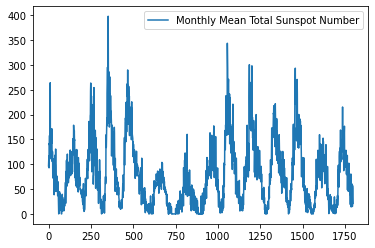

In [6]:
## plot the data
data.plot()

In [15]:
# Convert the data values to numpy for better and faster processing 
time_index = np.array(data['Date']) 
data = np.array(data['Monthly Mean Total Sunspot Number'])   

# ratio to split the data
SPLIT_RATIO = 0.8 

# Dividing into train-test split 
split_index = int(SPLIT_RATIO * data.shape[0])   

# Train-Test Split 
train_data = data[:split_index] 
train_time = time_index[:split_index]  
test_data = data[split_index:] 
test_time = time_index[split_index:]

In [16]:
## required parameters
WINDOW_SIZE = 60 
BATCH_SIZE = 32 
SHUFFLE_BUFFER = 1000 

## function to create the input features
def ts_data_generator(data, window_size, batch_size, shuffle_buffer):
    '''
    Utility function for time series data generation in batches
    '''
    ts_data = tf.data.Dataset.from_tensor_slices(data)
    ts_data = ts_data.window(window_size + 1, shift=1, drop_remainder=True)
    ts_data = ts_data.flat_map(lambda window: window.batch(window_size + 1))
    ts_data = ts_data.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    ts_data = ts_data.batch(batch_size).prefetch(1)
    return ts_data# Expanding data into tensors

tensor_train_data = tf.expand_dims(train_data, axis=-1)
tensor_test_data = tf.expand_dims(test_data, axis=-1)

## generate input and output features for training and testing set
tensor_train_dataset = ts_data_generator(tensor_train_data, WINDOW_SIZE, BATCH_SIZE, SHUFFLE_BUFFER)
tensor_test_dataset = ts_data_generator(tensor_test_data, WINDOW_SIZE, BATCH_SIZE, SHUFFLE_BUFFER)

In [17]:
# DHL Fusion model of 1D CNN and LSTM 
model = tf.keras.models.Sequential([tf.keras.layers.Conv1D(filters=32, kernel_size=5,strides=1, padding="causal",activation="relu",                       
                            input_shape=[None, 1]),
                            tf.keras.layers.LSTM(64, return_sequences=True), 
                            tf.keras.layers.LSTM(64, return_sequences=True),  
                            tf.keras.layers.Dense(30, activation="relu"),   
                            tf.keras.layers.Dense(10, activation="relu"),  
                            tf.keras.layers.Dense(1)])

In [18]:
## compile neural network model
optimizer = tf.keras.optimizers.SGD(lr=1e-3, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
## traing neural network model
history = model.fit(tensor_train_dataset, epochs=200, validation_data=tensor_test_dataset)

Epoch 1/200


/Users/gouravbais/opt/anaconda3/lib/python3.9/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


79/79 [==============================] - 12s 85ms/step - loss: 72.2088 - mae: 72.7025 - val_loss: 58.8200 - val_mae: 59.3187
Epoch 2/200
79/79 [==============================] - 6s 74ms/step - loss: 53.1237 - mae: 53.6224 - val_loss: 52.8331 - val_mae: 53.3310
Epoch 3/200
79/79 [==============================] - 6s 74ms/step - loss: 51.8888 - mae: 52.3864 - val_loss: 48.4501 - val_mae: 48.9479
Epoch 4/200
79/79 [==============================] - 7s 81ms/step - loss: 47.2850 - mae: 47.7827 - val_loss: 51.7302 - val_mae: 52.2285
Epoch 5/200
79/79 [==============================] - 8s 96ms/step - loss: 47.7456 - mae: 48.2434 - val_loss: 55.3550 - val_mae: 55.8531
Epoch 6/200
79/79 [==============================] - 7s 80ms/step - loss: 48.8693 - mae: 49.3672 - val_loss: 47.0571 - val_mae: 47.5541
Epoch 7/200
79/79 [==============================] - 6s 76ms/step - loss: 48.0260 - mae: 48.5235 - val_loss: 45.0241 - val_mae: 45.5217
Epoch 8/200
79/79 [==============================] - 6s 76m

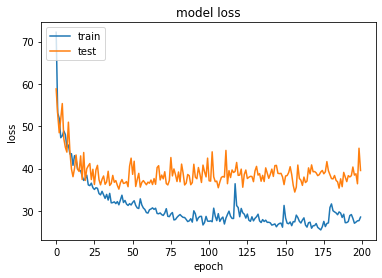

In [19]:
import matplotlib.pyplot as plt 
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [20]:
def model_forecast(model, data, window_size):
    ds = tf.data.Dataset.from_tensor_slices(data)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

rnn_forecast = model_forecast(model, data[..., np.newaxis], WINDOW_SIZE)
rnn_forecast = rnn_forecast[split_index - WINDOW_SIZE:-1, -1, 0]
# Overall Error
error = tf.keras.metrics.mean_absolute_error(test_data, rnn_forecast).numpy()
print(error)

31.842821


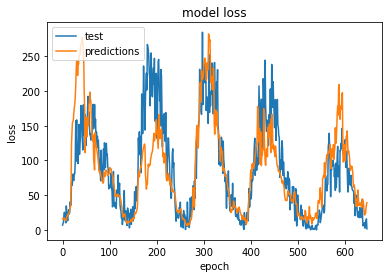

In [21]:
import matplotlib.pyplot as plt 
# summarize history for loss
plt.plot(test_data)
plt.plot(rnn_forecast)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['test', 'predictions'], loc='upper left')
plt.show()